# Protego: User-Centric Pose-Invariant Privacy Protection Against Face Recognition-Induced Digital Footprint Exposure

This notebook demonstrates how to use a pose-invariant privacy protection texture to protect a protectee's facial images from state-of-the-art retrieval-based face recognition systems, which try to retrieve all images in their face database that are related to the query images, resulting in a high recall rate. We will show that pose-invariant privacy protection texture can decrease the recall rate of these systems in three scenarios: Protected Query Clean DB (queries are protected and the images of the protectee in the database are unprotected), Clean Query Protected DB, and Protected Query Protected DB. 

In this example, we will use pretrained pose-invariant PPTs of the 20 protectees used in the paper to do performance evaluation on iResNetand50+AdaFace+CASIA and protect their images and videos. 

## Import libraries and modules

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" 

import torch
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
import cv2
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from protego.setup_user_uvs import init_flame, init_renderer, init_smirk, init_mp_lmk_detector
from protego.protect_vids import gen_vids
from protego.protect_imgs import protect_folder
from protego.utils import BASE_PATH
from protego.FacialRecognition import BASIC_POOL, SPECIAL_POOL
from protego.run import run1, run2
from protego.eval_mask import load_mask
from protego.analyze_res import ana_res
from mtcnn_pytorch.mtcnn import MTCNN

## Apply the PPTs to protect videos

We will apply the pretrained PPTs to the demo video. You can find the generated protected video under `results/vids/{protectee_name}/{dst_vid_name}.mp4`. See the configuration part of the following block for more personalizations choices. 

If you wish to run on your own videos (Your own videos' subjects must be within the 20 users we selected. You may choose your subject after the release of the training code.), follow the following steps. 
1. Create a folder for the protectee, e.g., `face_db/vids/Bruce_Willis`, and move the video(s) to be protected to the `face_db/vids` folder. The videos should be in `.mp4` format.
2. Specify the configurations in the code block below. 

In [3]:
with torch.no_grad():
    #################################################################
    # Configuration
    #################################################################
    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
    protectee = "Bradley_Cooper"  # The name of the protectee
    vid_name = "Bradley_Cooper"  # The name of the video to be protected
    mask_exp_name = ["default", "frpair0_mask0_univ_mask"] # You may change the first element to the name of the folder under experiments/, from which the PPT is loaded.
                                                            # No need to change the second if using pretrained PPTs. 
                                                            # The name of the experiment that contains the mask to be used
    epsilon = 16 # No need to change if using pretrained PPTs. 
                    # This has to correspond to the epsilon used in the mask generation, refer to the saved config file
    use_bin_mask = True # No need to change if using pretrained PPTs. 
                        # This has to correspond to the epsilon used in the mask generation, refer the saved config file
    compare_mode = True # Whether to put the unprotected and protected frames side by side. If False, only protected frames will be saved.
    #################################################################
    # Run
    #################################################################
    scr_vid_path = f"{BASE_PATH}/face_db/vids/{protectee}/{vid_name}.mp4"
    os.makedirs(os.path.join(BASE_PATH, 'results', 'vids', protectee), exist_ok=True)
    dst_vid_path = f"{BASE_PATH}/results/vids/{protectee}/{vid_name}_protected.mp4" if not compare_mode else f"{BASE_PATH}/results/vids/{protectee}/{vid_name}_compare.mp4"
    mask_src_path = f"{BASE_PATH}/experiments/{mask_exp_name[0]}/{protectee}/{mask_exp_name[1]}.npy"
    img_sz = 224
    epsilon /= 255. 
    mask = torch.tensor(np.load(mask_src_path), dtype=torch.float32, device=device).to(device)[[0]]
    
    smirk_weight_path = os.path.join(BASE_PATH, 'smirk/pretrained_models/SMIRK_em1.pt')
    mp_lmk_model_path = os.path.join(BASE_PATH, 'smirk/assets/face_landmarker.task')
    smirk_base_path = os.path.join(BASE_PATH, 'smirk')
    smirk_encoder = init_smirk(smirk_weight_path, device)
    flame = init_flame(smirk_base_path, device)
    renderer = init_renderer(smirk_base_path, device)
    lmk_detector = init_mp_lmk_detector(mp_lmk_model_path)
    detector = MTCNN(device=device, weight_paths={'pnet': os.path.join(BASE_PATH, 'mtcnn_pytorch', 'weights', 'pnet.npy'), 
                                                    'rnet': os.path.join(BASE_PATH, 'mtcnn_pytorch', 'weights', 'rnet.npy'), 
                                                    'onet': os.path.join(BASE_PATH, 'mtcnn_pytorch', 'weights', 'onet.npy')})
    gen_vids(mask=mask, 
            epsilon=epsilon,
            use_bin_mask=use_bin_mask,
            compare_mode=compare_mode,
            scr_vid_path=scr_vid_path,
            dst_vid_path=dst_vid_path,
            device=device,
            detector=detector, 
            img_sz=img_sz,
            lmk_detector=lmk_detector,
            smirk_encoder=smirk_encoder,
            flame=flame,
            renderer=renderer)

    print(f"The video has already been generated and saved to {dst_vid_path}. Please check the video in the folder.")



Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
I0000 00:00:1756520170.348260       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
W0000 00:00:1756520170.348500       1 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Using generic FLAME model


Generating video:  90%|████████▉ | 878/976 [08:04<00:43,  2.24it/s]

Face crop out of bounds in frame 877. Skipping...


Generating video:  95%|█████████▌| 930/976 [08:32<00:20,  2.26it/s]

Face crop out of bounds in frame 929. Skipping...


Generating video:  95%|█████████▌| 931/976 [08:32<00:17,  2.52it/s]

Face crop out of bounds in frame 930. Skipping...


Generating video:  95%|█████████▌| 932/976 [08:32<00:16,  2.68it/s]

Face crop out of bounds in frame 931. Skipping...


Generating video:  96%|█████████▌| 933/976 [08:32<00:15,  2.85it/s]

Face crop out of bounds in frame 932. Skipping...


Generating video:  96%|█████████▌| 934/976 [08:33<00:14,  2.90it/s]

Face crop out of bounds in frame 933. Skipping...


Generating video:  96%|█████████▌| 935/976 [08:33<00:13,  3.00it/s]

Face crop out of bounds in frame 934. Skipping...


Generating video:  96%|█████████▌| 936/976 [08:33<00:12,  3.09it/s]

Face crop out of bounds in frame 935. Skipping...


Generating video:  96%|█████████▌| 937/976 [08:34<00:12,  3.02it/s]

Face crop out of bounds in frame 936. Skipping...


Generating video:  98%|█████████▊| 953/976 [08:43<00:10,  2.15it/s]

Face crop out of bounds in frame 952. Skipping...


Generating video: 100%|██████████| 976/976 [08:56<00:00,  1.82it/s]

Processed 966 frames in 0:02:49.689456. Inference FPS: 5.69, Original Video FPS: 30.00
The video has already been generated and saved to /Users/wangziling/Desktop/Y2Summer/Protego/results/vids/Bradley_Cooper/Bradley_Cooper_compare.mp4. Please check the video in the folder.


## Apply the PPTs to images in a folder

We will apply the pretrained PPTs to the demo images. You can find the generated protected images under `results/imgs/{protectee_name}/`. See the configuration part of the following block for more personalizations choices. 

If you wish to run on your own images (Your own images' subjects must be within the 20 users we selected. You may choose your subject after the release of the training code.), follow the following steps. 
1. Create a folder for the protectee, e.g., `face_db/imgs/Bruce_Willis`, and move the image(s) to be protected to the `face_db/imgs` folder. The images can be in `.jpg`, `.jpeg`, `.png`, and `.bmp` formats. 
2. Specify the configurations in the code block below. 

Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
I0000 00:00:1756520122.062122       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
W0000 00:00:1756520122.062524       1 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Using generic FLAME model


Processing images: 0it [00:00, ?it/s][W MPSFallback.mm:11] Warning: The operator 'torchvision::nms' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (function operator())
Processing images: 5it [00:07,  1.47s/it]


Processed 5 images in 0:00:07.275378. Average time per image: 0:00:01.455076 seconds.
The protected images have already been generated. Check /Users/wangziling/Desktop/Y2Summer/Protego/results/imgs/Bradley_Cooper for the saved results.


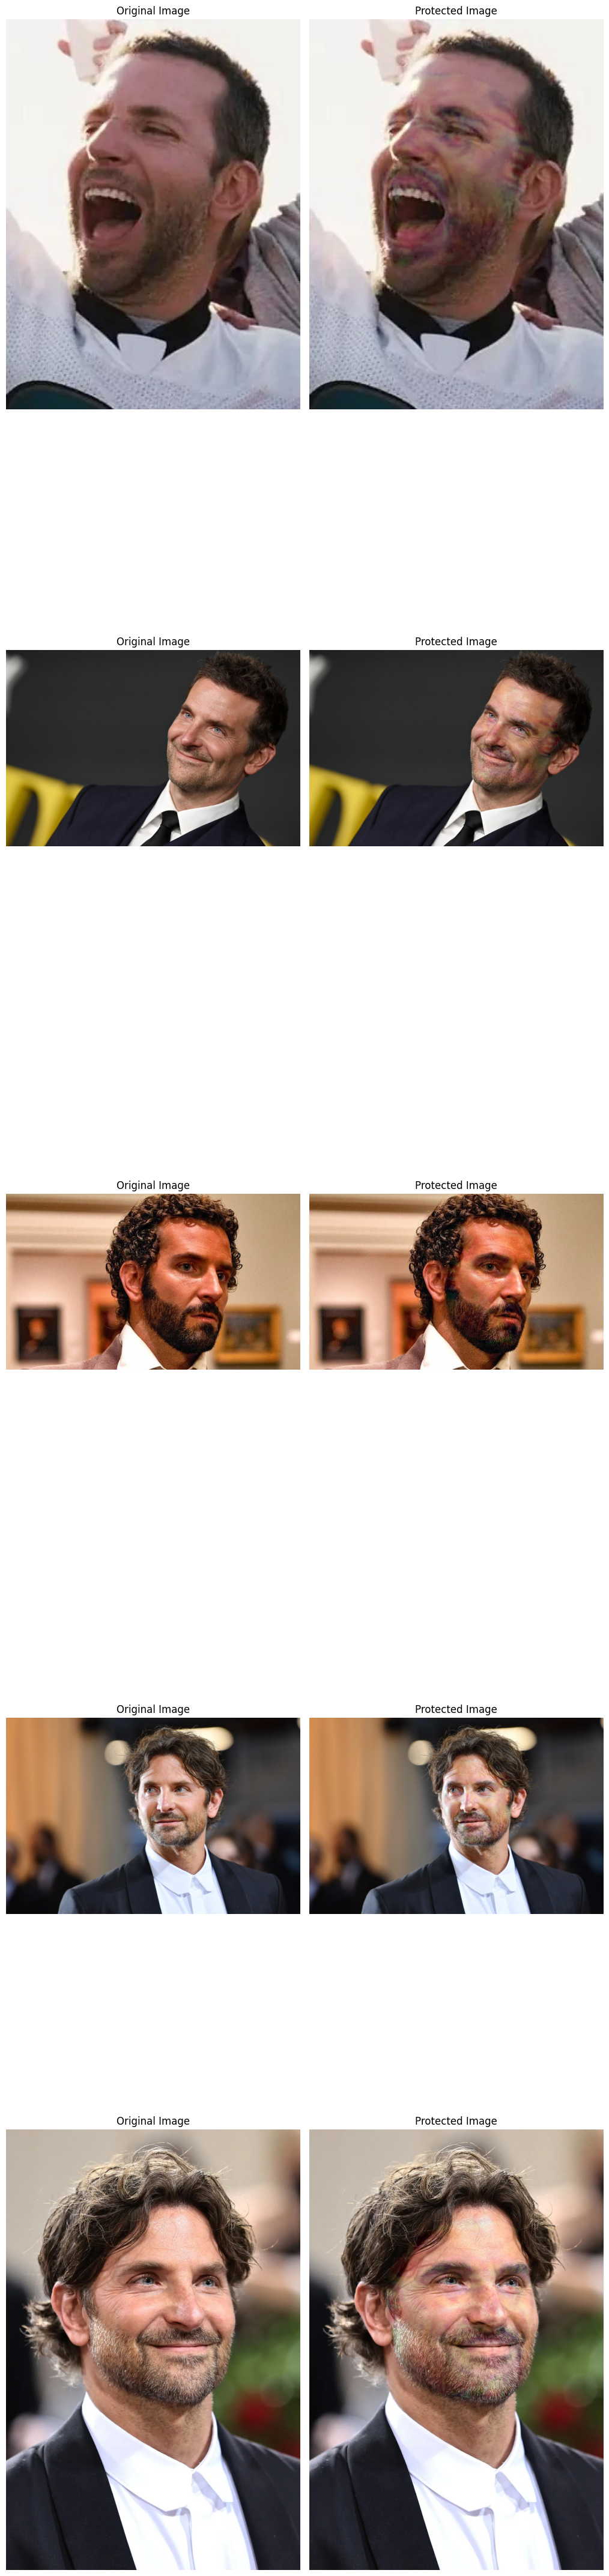

In [2]:
with torch.no_grad():
    #################################################################
    # Configuration
    #################################################################
    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
    protectee = "Bradley_Cooper"  # The name of the protectee
    mask_exp_name = ["default", "frpair0_mask0_univ_mask"] # The name of the experiment that contains the mask to be used
    epsilon = 16 # This has to correspond to the epsilon used in the mask generation, refer the saved config file
    use_bin_mask = True # This has to correspond to the epsilon used in the mask generation, refer the saved config file
    show = True # Whether to show the first protected images as a demo
    max_width = 1024 # Adjust this number according to your notebook's layout.
    #################################################################
    # Run
    #################################################################
    scr_imgs_path = f"{BASE_PATH}/face_db/imgs/{protectee}"
    dst_imgs_path = f"{BASE_PATH}/results/imgs/{protectee}"
    os.makedirs(dst_imgs_path, exist_ok=True)
    mask_src_path = f"{BASE_PATH}/experiments/{mask_exp_name[0]}/{protectee}/{mask_exp_name[1]}.npy"
    img_sz = 224
    epsilon /= 255. 
    mask = torch.tensor(np.load(mask_src_path), dtype=torch.float32, device=device).to(device)[[0]]
    detector = MTCNN(device=device, weight_paths={'pnet': os.path.join(BASE_PATH, 'mtcnn_pytorch', 'weights', 'pnet.npy'), 
                                                    'rnet': os.path.join(BASE_PATH, 'mtcnn_pytorch', 'weights', 'rnet.npy'), 
                                                    'onet': os.path.join(BASE_PATH, 'mtcnn_pytorch', 'weights', 'onet.npy')})
    smirk_weight_path = os.path.join(BASE_PATH, 'smirk/pretrained_models/SMIRK_em1.pt')
    mp_lmk_model_path = os.path.join(BASE_PATH, 'smirk/assets/face_landmarker.task')
    smirk_base_path = os.path.join(BASE_PATH, 'smirk')
    smirk_encoder = init_smirk(smirk_weight_path, device)
    flame = init_flame(smirk_base_path, device)
    renderer = init_renderer(smirk_base_path, device)
    lmk_detector = init_mp_lmk_detector(mp_lmk_model_path)

    protect_folder(mask=mask, 
                    epsilon=epsilon,
                    use_bin_mask=use_bin_mask,
                    scr_imgs_path=scr_imgs_path,
                    dst_imgs_path=dst_imgs_path,
                    device=device,
                    detector=detector,
                    img_sz=img_sz,
                    lmk_detector=lmk_detector,
                    smirk_encoder=smirk_encoder,
                    flame=flame,
                    renderer=renderer)
    print(f"The protected images have already been generated. Check {dst_imgs_path} for the saved results.")
    if show:
        fnames = sorted([i for i in os.listdir(scr_imgs_path) if i.endswith(('.jpg', '.jpeg', '.bmp', '.png'))])
        plt.figure(figsize=(max_width / 100, 12 * len(fnames)))
        for idx, fname in enumerate(fnames):
            protected_fname = f"{fname.split('.')[0]}_protected.jpg"
            plt.subplot(len(fnames), 2, idx * 2 + 1)
            plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(scr_imgs_path, fname)), cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.tight_layout()
            plt.axis("off")
            plt.subplot(len(fnames), 2, idx * 2 + 2)
            plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(dst_imgs_path, protected_fname)), cv2.COLOR_BGR2RGB))
            plt.title("Protected Image")
            plt.axis("off")
            plt.tight_layout()
        plt.tight_layout()
        plt.show()
        plt.close()

## Evaluate the PPTs and compare it with the base-line performance of the FRs

We will evaluate PPTs' protection performance on IR50-AdaFace-CASIA in three scenarios and compare it with the base-line performance of the FR. An evaluation graph will be plotted. The lower the bars and the higher the red dotted lines, the better the performance of the PPTs. Note that the only settings you can change are the `eval_fr_names` and `exp_name`, with which you can specify the FRs you want to evaluate PPTs with and the name of the evaluation experiment. 

Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]
Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]
Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]
Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]
Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]
Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]
Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]
Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]
Applying mask, extracting features, and evaluating visual quality: 100%|██████████| 2/2 [00:01<0

Evaluating 1/20: Bradley_Cooper
Evaluating 2/20: Bruce_Willis
Evaluating 3/20: Christina_Applegate
Evaluating 4/20: Courteney_Cox
Evaluating 5/20: Debra_Messing
Evaluating 6/20: Felicity_Huffman
Evaluating 7/20: Fran_Drescher
Evaluating 8/20: Geena_Davis
Evaluating 9/20: Hugh_Grant
Evaluating 10/20: Jon_Voight
Evaluating 11/20: Jonah_Hill
Evaluating 12/20: Julianna_Margulies
Evaluating 13/20: Julie_Benz
Evaluating 14/20: Kim_Cattrall
Evaluating 15/20: Kristin_Chenoweth
Evaluating 16/20: Lisa_Kudrow
Evaluating 17/20: Matthew_Perry
Evaluating 18/20: Michael_Weatherly
Evaluating 19/20: Sarah_Hyland
Evaluating 20/20: Sarah_Michelle_Gellar
Results for ir50_adaface_casia:
Clean Query & Protected DB: 0.0065
FR Baseline Performance: 0.7156
Protected Query & Protected DB: 0.1782
Protected Query & Clean DB: 0.0100
ssim: 0.9378
psnr: 31.0801
l0: 0.7091


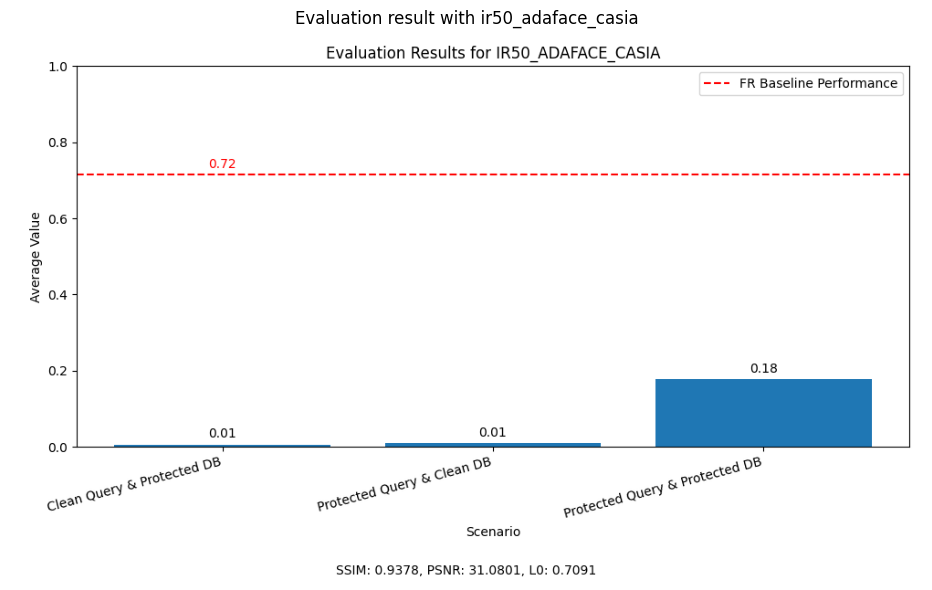

In [ ]:
####################################################################################################################
# Configuration
####################################################################################################################
# This code is adopted from the training code of Protego (which is currently not provided), therefore some configurations are not used in the evaluation.
configs = {
    # Useful configurations
    'device': 'cuda:0',  
    'exp_name': 'eval_default',  # The name of the subfolder under experiments/ where the evaluation results and visualizations will be saved.
    'protectees' : 'all',  # 'all', a list of protectees to include or exclude(add a '!' to the front of the list.), or the first(n>0)/last(n<0) n-1 protectees in the dataset
    'usage_portion' : 1.0, # The portion of the dataset visible to the model. 1.0 means all images are visible.
    'train_portion' : 0.6,  # The portion of the dataset to use for training. The rest will be used for testing.
    'query_portion': 0.5, # The portion of the test set to use for querying. The rest will be used as gallery.
    'random_split' : False,  # Whether to randomly split the dataset into train and test sets.
    'shuffle' : False, # Whether to shuffle the dataset before splitting.
    'bin_mask': True, # Whether to use binary mask. If True, the perturbation will be restricted to the face area. 
    'eval_scene': 1, # 0: When evaluating one user, the rest of the selected users will not be included in the noise db. 1: When evaluating one user, the rest of the selected users will be included in the noise db.
    'vis_eval': True, # Whether to evaluate the visual quality of the mask. 
    'compression_eval': False, # Whether to evaluate the compression of the mask.
    'visualize_interval': 1, # Visualize the mask every n test images. Set it to any value <= 0 to disable saving additional masks.
    'eval_fr_names': ['ir50_adaface_casia'], # The names of the facial recognition models to use for evaluation. You may choose from BASIC_POOL and SPECIAL_POOL.
    'mask_name': ['default', 'frpair0_mask0_univ_mask.npy'], # Only the first element need to be changed. The first element is the name of the folder in 'experiments' of which the mask is loaded from. The second element is the name of the mask file to load. 
    'eval_compression_methods': ['gaussian', 'median', 'jpeg', 'resize'], # The compression methods to evaluate.
    'compression_cfgs' : {
        # Gaussian Filter
        'gaussian': {
            'kernel_size': 9, 
            'sigma': 2.0,
        }, 
        # Median Filter
        'median': {
            'kernel_size': 9
        }, 
        # JPEG Compression
        'jpeg': {
            'quality': 70, 
        }, 
        # Resize
        'resize': {
            'resz_percentage': 0.4,  # Resize the image to 50% of its original size
            'mode': 'bicubic'
        }
    }, 

    # The configurations below are useless for evaluation or should not be changed. But they are required for the code to run.
    'three_d': True, 
    'epoch_num': 100,  
    'batch_size' : 4,  
    'epsilon' : 16 / 255., 
    'min_ssim' : 0.95, 
    'learning_rate' : 0.01 * (16 / 255.), # 0.01 * (16 / 255.)
    'mask_size' : 224, 
    'mask_seeds': [114],  #[114, 514, 191, 98, 10, 42, 35] will also serve as the round of experiments for each fr_pair and each person. 
    'global_random_seed' : 42,  # The global random seed for reproducibility. Random initialization of the mask will use different seeds for each round of experiments as defined in 'mask_seeds'.
    'eval_db' : "face_scrub", # The database to use for evaluation.
    'save_univ_mask': False, # Whether to save the universal mask as npy after training. 
    'save_additional_mask_interval': -1, # Save the additional masks every n test images. Set it to any value <= 0 to disable saving additional masks.
    'fr_pairs' : [(["ir50_adaface_casia"], ["ir50_adaface_casia"])]
}
####################################################################################################################
# Run
####################################################################################################################
cfgs = OmegaConf.create(configs)
_fr_pair = list(cfgs.fr_pairs[0])
_fr_pair[1] = cfgs.eval_fr_names
cfgs.fr_pairs[0] = tuple(_fr_pair)
torch.manual_seed(cfgs.global_random_seed)
if cfgs.eval_scene == 0:
    run1(load_mask, cfgs)
elif cfgs.eval_scene == 1:
    run2(load_mask, cfgs)

ana_res(cfgs.exp_name, cfgs.compression_eval)
plt.figure(figsize=(10, 6*len(cfgs.eval_fr_names)))
for name_idx, eval_fr_name in enumerate(cfgs.eval_fr_names):
    plt.subplot(len(cfgs.eval_fr_names), 1, name_idx+1)
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(BASE_PATH, 'results', 'eval', cfgs.exp_name, f'{eval_fr_name}_evaluation_results.png')), cv2.COLOR_BGR2RGB))
    plt.title(f"Evaluation result with {eval_fr_name}")
    plt.tight_layout()
    plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()
if cfgs.compression_eval:
    print(f"For evaluation results on the PPTs' robustness against compressions, check {os.path.join(BASE_PATH, 'results', 'eval', cfgs.exp_name)} for results.")

